In [30]:
import random as random
import time as time
import heapq as heapq
import matplotlib.pyplot as plt # 画曲线图
import numpy as np #拟合直线

class HyperNode:
    def __init__(self,id,degree,edges):
        self.id = id
        self.degree = degree
        self.edges = edges

    def __lt__(self,other):
        return self.id<other.id
    
    def print(self):
        print("id:" + str(self.id))
        print("degree:" + str(self.degree))
        print("edges: "+ str(self.edges))

class HyperEdge:
    def __init__(self,id,degree,nodes):
        self.id = id
        self.degree = degree 
        self.nodes = nodes
        
    def print(self):
        print("id:" + str(self.id))
        print("degree:" + str(self.degree))
        print("edges: "+ str(self.nodes))

# # return: mp_node,mp_edge
# def load_data(path):
#     # input:
#     # path: data set path
    
#     # return: 
#     # mp_node: dict of partition node n_id:HyperNode
#     # mp_edge: dict of partition edge e_id:HyperEdge
    
#     mp_node = {}
#     mp_edge = {}
#     with open(path,'r') as f:
#         for line in f:
#             if(line[0]=='#' or line=='\n') : continue
#             data = [int(i) for i in line[0:-1].split(" ")]
#             n_id = data[0]
#             n_degree = data[1]
#             n_edges = set(data[2:])
#             if mp_node.get(n_id) == None : 
#                 mp_node[n_id] = HyperNode(n_id,n_degree,n_edges)
#                 tmp[n_id] = HyperNode(n_id,n_degree,n_edges)
#             for edge in n_edges:
#                 if mp_edge.get(edge) == None:
#                     mp_edge[edge] = HyperEdge(edge,0,set())
#                 mp_edge[edge].degree += 1
#                 mp_edge[edge].nodes.add(n_id)
#     return mp_node,mp_edge

# return: mp_node,mp_edge
def load_data(path):
    # input:
    # path: data set path
    
    # return: 
    # mp_node: dict of partition node n_id:HyperNode
    # mp_edge: dict of partition edge e_id:HyperEdge
    
    mp_node = {}
    mp_edge = {}
    with open(path,'r') as f:
        for line in f:
#             print(line[0:-1].split(" "))
            n_id,e_id = line[0:-1].split(" ")
            if mp_node.get(n_id) == None : 
                mp_node[n_id] = HyperNode(n_id,0,set())
            if mp_edge.get(e_id) == None :
                mp_edge[e_id] = HyperEdge(e_id,0,set())
                
            mp_node[n_id].degree += 1
            mp_edge[e_id].degree += 1
            mp_node[n_id].edges.add(e_id)
            mp_edge[e_id].nodes.add(n_id)
    return mp_node,mp_edge

# return: None
def recoder(part_node,mp_node,mp_edge,path):
    # input:
    # part_node: result of partition node
    # mp_node: dictionary of hyper node 
    # mp_edge: dictionary of hyper edge
    # path: path to save record result
    
    dic = {}
    tot = 0
    for par in part_node:
        for node in par:
            dic[node.id] = len(dic)

    print(path+"/record.txt")
    with open(path+"/record.txt",'w') as f:
        for par in part_node:
            for node in par:
                for edge in node.edges:
                    f.write(str(dic[node.id])+" "+str(edge)+"\n")
# return: part_node,part_edge

def solve(p,mp_node,mp_edge,prop = 1.0,k=1,shield_heavy_edge = 1e9 ,buffer_fac = 5,debug = False):
    # input : 
    # p: partition number 
    # mp_node: dict of partition nodes  
    # mp_edge: dict of partition edges
    # prob: accelerate factory to add node
    # k: select topk node at once
    # shield_heavy_node: filter huge edge 
    # debug: print debug infomation
    
    # return :
    # part_node: list of partition node set 
    # part_edge: list of partition edge set
    
    random.seed(19990320)
    node_number = len(mp_node)
    cur_p = 0
    maxi_cap = node_number/p + 1
    part_node = [set() for i in range(p)]
    part_edge = [set() for i in range(p)]
    mp_eval = {i:0 for i in mp_node.keys()}
    
    ave_hyperedge_degree = 0
    edge_degree_list = set()
    for edge in mp_edge.values():   
        ave_hyperedge_degree += edge.degree/len(mp_edge)
        edge_degree_list.add(edge.degree)
#     print(edge_degree_list)
    edge_degree_list = list(edge_degree_list)
    edge_degree_list.sort()
#     print(edge_degree_list)
#     print(len(mp_edge)/2)
#     print("2*ave:",ave_hyperedge_degree," mid:",edge_degree_list[int(len(edge_degree_list)/2)])
    ave_hyperedge_degree = edge_degree_list[int(len(edge_degree_list)/2)]

    cnt = 0
    select_node = []
    heap_size = buffer_fac*k
    check = set()
    while len(mp_node)!=0:
        cnt += 1
        if cnt % 100 == 0 and debug : print (cnt)
            
        add_node = []
        
        if len(select_node) <= k:
            check.clear()
            select_node = []
            for node in mp_node.values():   
                if mp_eval[node.id]/node.degree >= prop:
                    add_node.append(node)
#                     check.add(node)
                    continue
                if  len(select_node) < heap_size:
                    heapq.heappush(select_node,(mp_eval[node.id],node))
                    check.add(node)
                else :
                    if mp_eval[node.id] > select_node[0][0] :
                        rank,remove_node = heapq.heappop(select_node)
                        check.remove(remove_node)
                        heapq.heappush(select_node,(mp_eval[node.id],node))
                        check.add(node)
        
        for i in range(min(k,len(select_node))):
            rank,node = heapq.heappop(select_node)
            check.remove(node)
            add_node.append(node)

        for par_node in add_node:
            if len(part_node[cur_p]) >= maxi_cap :
                break
            part_node[cur_p].add(par_node)
            for edge in par_node.edges:
                if edge not in part_edge[cur_p]:
                    part_edge[cur_p].add(edge)
                    if mp_edge[edge].degree > shield_heavy_edge: continue
                    for node in mp_edge[edge].nodes:
                        if mp_node.get(node) == None : continue
                        mp_eval[node] += 1
#                         print(len(select_node))
            del mp_node[par_node.id] 
#             check.remove(par_node)
        select_node = [(mp_eval[node.id],node)for rank,node in select_node]
        heapq.heapify(select_node)

        if len(part_node[cur_p]) >= maxi_cap : # next partition pre-process
            for key in mp_eval.keys():
                mp_eval[key] = 0
            cur_p += 1   
            
    return part_node,part_edge



def degree_distribute(mp_node,show = True,logx=True,logy=True,coeff = True,cumulation = True): # draw degree distribute graph 
    degree = mp_node
    dic = {j.degree:0 for i,j in degree.items()}
    
    for i,j in degree.items(): dic[j.degree] += 1
    
    ls = sorted(dic.items(), key = lambda x:(x[0],x[1]))
        
    x = [i[0] for i in ls]
    y = [i[1] for i in ls]

    if x[0] == 0:
        x = x[1:-1]
        y = y[1:-1]
    
    if cumulation == True : 
        cnt = sum(y)
        for i in range(len(x)):
            cnt -= y[i]
            y[i] += cnt

    if show == True :
        plt.plot(x,y, 'o',color='b')
        if logy : plt.yscale('log')
        if logx : plt.xscale('log')
        

    if coeff == True : 

        xx = [np.log2(i) for i in x]
        yy = [np.log2(i) for i in y]
        
        k,b = np.polyfit(xx, yy, 1)
#         lg = yy[0]/xx[-1]
#         lg = 1/lg
        print("alpha: "+str(k))
        
        xx = x
        yy = [(i**k)*(2**b) for i in xx]
        plt.plot(xx,yy,color='r')
    plt.show()

    return [(x[i],y[i]) for i in range(len(x))]


alpha: -1.733355505918805


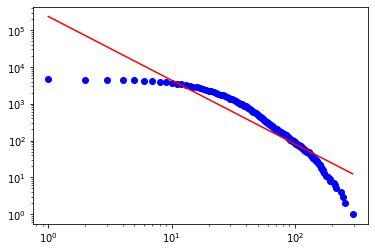

1   28988
2   28843
3   28013
4   27322
5   26824
6   26459
7   25697
8   24992
9   24154
10   23976
11   23435
12   23567
13   23172
14   22739
15   22481
16   22312
17   22185
18   21816
19   21631
20   21328
21   21577
22   21045
23   20783
24   20608
25   20717
26   20823
27   20590
28   20712
29   20440
30   20234
31   20251
32   20278
33   20245
34   20090
35   20106
36   20267
37   19960
38   20139
39   20084
40   20054
41   19882
42   19887
43   19913
44   19623
45   19827
46   19791
47   19756
48   19444
49   19757
50   19560
51   19736
52   19423
53   19657
54   19558
55   19506
56   19686
57   19468
58   19654
59   19568
60   19466
61   19389
62   19545
63   19508
64   19543
65   19536
66   19364
67   19532
68   19627
69   19627
70   19730
71   19836
72   19701
73   19556
74   19742
75   19694
76   19399


KeyboardInterrupt: 

In [31]:
# path = "./data/github/github.txt"
path = "./data/wiki/wiki.txt"
p = 16
mp_node,mp_edge = load_data(path)
ls = degree_distribute(mp_node)
for turn in range(ls[0][0],ls[-1][0],1):
#     p*=2
    mp_node,mp_edge = load_data(path)
#     degree_distribute(mp_node)
    time_beg = time.time()
    prop = 1.1
    k = 10
    buffer_fac = 1
    shield_heavy_edge = turn
    part_node,part_edge = solve(p,mp_node,mp_edge,prop,k,buffer_fac = buffer_fac,shield_heavy_edge = shield_heavy_edge)  
    time_end = time.time()
    mp_node,mp_edge = load_data(path)
    # recoder(part_node,mp_node,mp_edge,"./data/wiki")
    k_1 = sum([len(i) for i in part_edge]) - len(mp_edge)
#     print(turn," ",k_1)
    print("parameter:\n","p:",p," prop:","%.2f"%prop," k:",k," buffer_fac:",buffer_fac,
          " sheld_size:",shield_heavy_edge)
    print("result:\n","runtime:",int((time_end-time_beg)*1000),"ms k-1:",k_1)
    print("---------------------------------------")
#  runtime: 11999 ms k-1: 27102
    

alpha: -1.6363240049196743


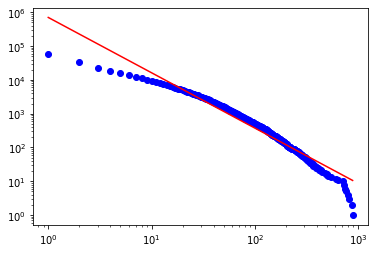

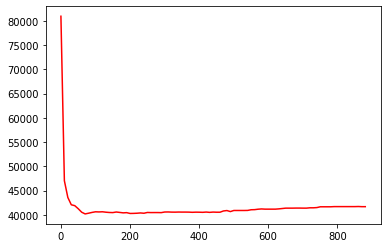

In [37]:
def test_shield():
    x = []
    y = []
#     path = "./data/wiki/wiki.txt"
    path = "./data/github/github.txt"
    p = 16
    mp_node,mp_edge = load_data(path)
    ls = degree_distribute(mp_node)
    for turn in range(ls[0][0],ls[-1][0],10):
    #     p*=2
        mp_node,mp_edge = load_data(path)
    #     degree_distribute(mp_node)
        time_beg = time.time()
        prop = 1.1
        k = 10
        buffer_fac = 1
        shield_heavy_edge = turn
        part_node,part_edge = solve(p,mp_node,mp_edge,prop,k,buffer_fac = buffer_fac,shield_heavy_edge = shield_heavy_edge)  
        time_end = time.time()
        mp_node,mp_edge = load_data(path)
        # recoder(part_node,mp_node,mp_edge,"./data/wiki")
        k_1 = sum([len(i) for i in part_edge]) - len(mp_edge)
#         print(turn," ",k_1)
        x.append(turn)
        y.append(k_1)
    plt.plot(x,y,color='r')
    plt.show()
    return x,y
    
x,y = test_shield()

In [23]:
tmp_node = [set() for i in range(p)]

for par in range(len(part_edge)):
    for i in part_node[par]: tmp_node[par].add(i.id)
    cnt = 0
    print("edges:"+str(len(part_edge[par])))
    print("nodes:"+str(len(part_node[par])))
    for edge in part_edge[par]:
        for node in mp_edge[edge].nodes:
#             print(node)
#             print(mp_node[node])
            if node in tmp_node[par]:
                cnt += 1
    cur_p += 1
    print(cnt)
    

edges:56433
nodes:5653
277912
edges:25730
nodes:5653
59056
edges:15618
nodes:5653
28610
edges:7641
nodes:5653
14208
edges:7349
nodes:5653
12455
edges:7531
nodes:5653
11444
edges:7756
nodes:5653
10089
edges:8023
nodes:5653
9310
edges:7767
nodes:5653
8748
edges:7984
nodes:5642
8405


In [4]:
k_1 = sum([len(i) for i in part_edge]) - edge_number
print(k_1)

30965
